In [1]:
from dolfin import Constant, Expression, plot, inner, interpolate, assemble, Function, norm
from dolfin.common.plotting import mplot_function

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../../')
from reaktoro_transport.problem import DarcyFlowMixedPoisson, DarcyFlowUzawa
from reaktoro_transport.mesh import MarkedRectangleMesh

%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [2]:
mesh_factory = MarkedRectangleMesh()

In [3]:
mesh_factory.set_bottom_left_coordinates(coord_x = 0.0, coord_y = 0.0)
mesh_factory.set_top_right_coordinates(coord_x = 1.0, coord_y = 1.0)
mesh_factory.set_number_of_elements(15, 15)
mesh_factory.set_mesh_type('triangle')
mesh = mesh_factory.generate_mesh()
boundary_markers, marker_dict = mesh_factory.generate_boundary_markers()
domain_markers = mesh_factory.generate_domain_markers()

In [4]:
class DarcyFlowBenchmarkProblem(DarcyFlowMixedPoisson):
    
    def get_flow_rate(self, marker: int):
        
        flow_rate = assemble(inner(self.fluid_velocity, self.n)*self.ds(marker))
        
        return flow_rate
    
    def get_permeability(self, marker: int):
        
        aperture_size = 1.0
        flow_rate = assemble(inner(self.fluid_velocity, self.n)*self.ds(marker))
        cross_section_area = assemble(Constant(1.0)*self.ds(marker))*aperture_size
        sample_length = 1.0
        delta_p = 1.0
        viscosity = self._mu.values()[0]
        
        permeability = flow_rate*viscosity*sample_length/(cross_section_area*delta_p)
        
        return permeability

In [5]:
problem = DarcyFlowBenchmarkProblem(mesh, boundary_markers, domain_markers)

In [6]:
problem.mark_flow_boundary(pressure = [marker_dict['left'], marker_dict['right']], 
                           velocity = [marker_dict['top'], marker_dict['bottom']])

problem.set_pressure_fe_space('DG', 0)
problem.set_velocity_fe_space('BDM', 1)

problem.set_permeability(Expression('x[0]<0.67 ? (x[0]<0.34 ? 1000.0 : 1.0) : 200.0', degree=0))
problem.set_porosity(Constant(1.0))
problem.set_fluid_density(1.0)
problem.set_fluid_viscosity(1.0)
problem.set_gravity((0.0, 0.0))

problem.set_pressure_bc([Constant(1.0), Constant(0.0)])
problem.generate_form()
problem.set_mixed_velocity_bc([Constant((0.0, 0.0))]*2)

problem.set_solver()
problem.assemble_matrix()

In [7]:
%%time

problem.solve_flow()

CPU times: user 15 ms, sys: 796 µs, total: 15.7 ms
Wall time: 15.7 ms


In [8]:
velocity = problem.get_fluid_velocity()
pressure = problem.get_fluid_pressure()

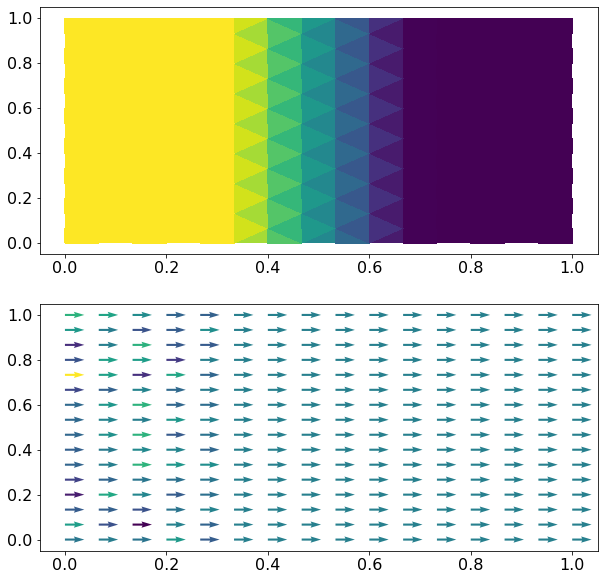

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

mplot_function(ax[0], pressure)
mplot_function(ax[1], velocity)
plt.show()

In [10]:
# The permeability of our solver should correspond to the harmonic average of permeabilities.

permeability = np.array([1000.0, 1.0, 200.0])
harmonic_average = 1.0/np.mean(1.0/permeability)

print(harmonic_average)
problem.get_permeability(marker_dict['right'])

2.982107355864812


2.982107355864811